### Libs

In [185]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np
from pandas.core.computation.pytables import Timedelta

import matplotlib.pyplot as plt

In [186]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
pd.set_option('display.max_columns', None)

### Data loading

In [187]:
df = pd.read_csv('sample_data/df_for_EDA.csv')

In [244]:
df.head(3)

,Kline open time,time,Open price,High price,Low price,Close price,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,1672531200000,2023-01-01 00:00:00,72.38,72.39,72.36,72.39,782.0,56602.48,17,560.0,40536.27
1,1672532100000,2023-01-01 00:15:00,72.39,72.39,72.37,72.37,3706.0,268254.08,22,2484.0,179809.76
2,1672533000000,2023-01-01 00:30:00,72.39,72.39,72.38,72.39,1197.0,86649.00,19,1014.0,73403.46


In [189]:
df['time'] = pd.to_datetime(df['time'])

In [190]:
df.drop(index=[7918, 7919, 7920, 7921, 7922], axis=0, inplace=True)

In [191]:
df.drop_duplicates(subset=['Kline open time'], inplace=True)

In [192]:
ti = pd.date_range(start = df.time.min(), end = df.time.max(), freq="15min") # интерполяционная сетка
ts = pd.DataFrame({'date':list(ti)})
ts['unixtime'] = (ts.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')

In [193]:
upsampled_Open_price = np.interp(ts.unixtime, df['Kline open time'], df['Open price'])
upsampled_High_price = np.interp(ts.unixtime, df['Kline open time'], df['High price'])
upsampled_Low_price = np.interp(ts.unixtime, df['Kline open time'], df['Low price'])
upsampled_Close_price = np.interp(ts.unixtime, df['Kline open time'], df['Close price'])

In [194]:
data = pd.DataFrame({'unixtime': ts.unixtime, 'Open_price': upsampled_Open_price,
                       'High_price': upsampled_High_price, 'Low_price': upsampled_Low_price, 'Close_price': upsampled_Close_price})

In [195]:
data.insert(1, "time", pd.to_datetime(data.unixtime, unit='ms').to_list())
data.drop('unixtime', axis=1, inplace=True)

In [196]:
# Фкц для определения трети 
def third_calc(High_price, Low_price, calc_price):
    movement = (High_price-Low_price)/3
    body = calc_price-Low_price
    if body<movement:
        third = 3
    elif body<2*movement:
        third = 2
    else:
        third = 1
    return third

In [197]:
# определяем, как аггрегировать данные в колонках
conversion = {
    'Open_price'  :  'first',  
    'High_price' :  'max', 
    'Low_price':  'min', 
    'Close_price': 'last'
}

data.set_index('time', inplace=True)
# уменьшаем частоту данных до 1 часа, аггрегируем данные, как описано выше, плюс смещаем на один шаг(час)
downsampled = data.resample('1H').apply(conversion).shift(1)
# возвращаем время из индекса в отдельную колонку
data = data.reset_index()
downsampled = downsampled.reset_index()

In [198]:
data = data.merge(downsampled, how = 'left', on='time', suffixes=('', '_by_hour')).fillna(method="ffill")

In [199]:
# Признак роста на часовом интервале (красная или зеленая свеча)
data['hour_is_green'] = np.where(data['Open_price_by_hour']<data['Close_price_by_hour'], 1,0)
# Признак трети открытия на часовом интервале
data['hour_open_thirds'] = data.apply(lambda x: third_calc(x.High_price_by_hour, x.Low_price_by_hour, x.Open_price_by_hour), axis=1)
# Признак трети закрытия на часовом интервале
data['hour_close_thirds'] = data.apply(lambda x: third_calc(x.High_price_by_hour, x.Low_price_by_hour, x.Close_price_by_hour), axis=1)

In [200]:
data_ts = data.time.copy()
data.drop(['time','Open_price', 'High_price', 'Low_price', 'Open_price_by_hour','High_price_by_hour','Low_price_by_hour','Close_price_by_hour'], axis=1, inplace=True)

In [201]:
# Генерируем новые признаки, сдвигая целевой ряд.
# Получаем сдвиг на сутки
for lag in range(1,96):
    data[f"lag{lag}"] = data.Close_price.transform(lambda x: x.shift(lag))

In [202]:
data.dropna(inplace=True)
data = data.reset_index(drop=True)

In [203]:
data.head(5)

,Close_price,hour_is_green,hour_open_thirds,hour_close_thirds,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,lag72,lag73,lag74,lag75,lag76,lag77,lag78,lag79,lag80,lag81,lag82,lag83,lag84,lag85,lag86,lag87,lag88,lag89,lag90,lag91,lag92,lag93,lag94,lag95
0,72.30,1,3,1,72.31,72.31,72.32,72.38,72.31,72.35,72.26,72.25,72.22,72.22,72.24,72.22,72.23,72.23,72.23,72.23,72.25,72.26,72.22,72.27,72.17,72.21,72.19,72.12,72.21,72.23,72.26,72.28,72.20,72.27,72.23,72.15,72.22,72.21,72.31,72.22,72.22,72.34,72.31,72.34,72.32,72.27,72.19,72.29,72.25,72.28,72.15,72.25,72.38,72.33,72.38,72.40,72.37,72.43,72.44,72.52,72.43,72.45,72.42,72.40,72.40,72.40,72.40,72.38,72.39,72.38,72.40,72.40,72.38,72.40,72.39,72.39,72.38,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.39,72.39,72.38,72.38,72.39,72.38,72.39,72.38,72.38,72.39,72.37,72.39
1,72.30,0,1,3,72.30,72.31,72.31,72.32,72.38,72.31,72.35,72.26,72.25,72.22,72.22,72.24,72.22,72.23,72.23,72.23,72.23,72.25,72.26,72.22,72.27,72.17,72.21,72.19,72.12,72.21,72.23,72.26,72.28,72.20,72.27,72.23,72.15,72.22,72.21,72.31,72.22,72.22,72.34,72.31,72.34,72.32,72.27,72.19,72.29,72.25,72.28,72.15,72.25,72.38,72.33,72.38,72.40,72.37,72.43,72.44,72.52,72.43,72.45,72.42,72.40,72.40,72.40,72.40,72.38,72.39,72.38,72.40,72.40,72.38,72.40,72.39,72.39,72.38,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.39,72.39,72.38,72.38,72.39,72.38,72.39,72.38,72.38,72.39,72.37
2,72.31,0,1,3,72.30,72.30,72.31,72.31,72.32,72.38,72.31,72.35,72.26,72.25,72.22,72.22,72.24,72.22,72.23,72.23,72.23,72.23,72.25,72.26,72.22,72.27,72.17,72.21,72.19,72.12,72.21,72.23,72.26,72.28,72.20,72.27,72.23,72.15,72.22,72.21,72.31,72.22,72.22,72.34,72.31,72.34,72.32,72.27,72.19,72.29,72.25,72.28,72.15,72.25,72.38,72.33,72.38,72.40,72.37,72.43,72.44,72.52,72.43,72.45,72.42,72.40,72.40,72.40,72.40,72.38,72.39,72.38,72.40,72.40,72.38,72.40,72.39,72.39,72.38,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.39,72.39,72.38,72.38,72.39,72.38,72.39,72.38,72.38,72.39
3,72.31,0,1,3,72.31,72.30,72.30,72.31,72.31,72.32,72.38,72.31,72.35,72.26,72.25,72.22,72.22,72.24,72.22,72.23,72.23,72.23,72.23,72.25,72.26,72.22,72.27,72.17,72.21,72.19,72.12,72.21,72.23,72.26,72.28,72.20,72.27,72.23,72.15,72.22,72.21,72.31,72.22,72.22,72.34,72.31,72.34,72.32,72.27,72.19,72.29,72.25,72.28,72.15,72.25,72.38,72.33,72.38,72.40,72.37,72.43,72.44,72.52,72.43,72.45,72.42,72.40,72.40,72.40,72.40,72.38,72.39,72.38,72.40,72.40,72.38,72.40,72.39,72.39,72.38,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.39,72.39,72.38,72.38,72.39,72.38,72.39,72.38,72.38
4,72.28,0,1,3,72.31,72.31,72.30,72.30,72.31,72.31,72.32,72.38,72.31,72.35,72.26,72.25,72.22,72.22,72.24,72.22,72.23,72.23,72.23,72.23,72.25,72.26,72.22,72.27,72.17,72.21,72.19,72.12,72.21,72.23,72.26,72.28,72.20,72.27,72.23,72.15,72.22,72.21,72.31,72.22,72.22,72.34,72.31,72.34,72.32,72.27,72.19,72.29,72.25,72.28,72.15,72.25,72.38,72.33,72.38,72.40,72.37,72.43,72.44,72.52,72.43,72.45,72.42,72.40,72.40,72.40,72.40,72.38,72.39,72.38,72.40,72.40,72.38,72.40,72.39,72.39,72.38,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.38,72.39,72.39,72.39,72.39,72.38,72.38,72.39,72.38,72.39,72.38


### train_test split с помощью numpy

In [204]:
# На тест мы оставим 1 час, а трейн и валидацию поделим в соотношении 3 к 1
last_id = data.index.stop
test = data.loc[last_id-5:]
train, val = np.split(data.loc[:last_id-6], [int(.75 *len(data))])

In [205]:
column_indices = {name: i for i, name in enumerate(data.columns)}
num_features = data.shape[1]

In [206]:
train.shape, val.shape, test.shape

((7966, 99), (2651, 99), (5, 99))

In [207]:
train.index, val.index, test.index

(RangeIndex(start=0, stop=7966, step=1),
 RangeIndex(start=7966, stop=10617, step=1),
 RangeIndex(start=10617, stop=10622, step=1))

In [208]:
train_index = train.index
val_index = val.index
test_index = test.index

### Normalize the data

In [210]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
val = (val - train_mean) / train_std
test = (test - train_mean) / train_std

In [211]:
train

,Close_price,hour_is_green,hour_open_thirds,hour_close_thirds,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,lag72,lag73,lag74,lag75,lag76,lag77,lag78,lag79,lag80,lag81,lag82,lag83,lag84,lag85,lag86,lag87,lag88,lag89,lag90,lag91,lag92,lag93,lag94,lag95
0,-0.325718,1.021509,1.219960,-1.108629,-0.322471,-0.322288,-0.319041,-0.300471,-0.321742,-0.309297,-0.336705,-0.339588,-0.348605,-0.348422,-0.342105,-0.348057,-0.344806,-0.344623,-0.344441,-0.344258,-0.337937,-0.334686,-0.346784,-0.331249,-0.361778,-0.349310,-0.355272,-0.376594,-0.348759,-0.342430,-0.333028,-0.326700,-0.351111,-0.329409,-0.341527,-0.365946,-0.344236,-0.347129,-0.316186,-0.343696,-0.343515,-0.306406,-0.315458,-0.306042,-0.312016,-0.327228,-0.351681,-0.320702,-0.332841,-0.323418,-0.363286,-0.332293,-0.292051,-0.307282,-0.291693,-0.285349,-0.294420,-0.275742,-0.272479,-0.247626,-0.275208,-0.268861,-0.277938,-0.283931,-0.283752,-0.283571,-0.283388,-0.289380,-0.286110,-0.289015,-0.282655,-0.282472,-0.288469,-0.282107,-0.285014,-0.284832,-0.287742,-0.284469,-0.287378,-0.284105,-0.283921,-0.286831,-0.283555,-0.283371,-0.286282,-0.283005,-0.282822,-0.282640,-0.282457,-0.285370,-0.285187,-0.281908,-0.284823,-0.281542,-0.284459,-0.284277,-0.280997,-0.287012,-0.280628
1,-0.325718,-0.978821,-1.160786,1.295110,-0.325535,-0.322288,-0.322105,-0.318860,-0.300285,-0.321560,-0.309110,-0.336522,-0.339404,-0.348422,-0.348240,-0.341921,-0.347875,-0.344623,-0.344441,-0.344258,-0.344077,-0.337756,-0.334502,-0.346604,-0.331063,-0.361597,-0.349128,-0.355086,-0.376415,-0.348577,-0.342249,-0.332848,-0.326516,-0.350933,-0.329226,-0.341342,-0.365767,-0.344053,-0.346953,-0.316003,-0.343515,-0.343339,-0.306224,-0.315277,-0.305858,-0.311831,-0.327043,-0.351503,-0.320519,-0.332661,-0.323230,-0.363109,-0.332117,-0.291870,-0.307106,-0.291515,-0.285169,-0.294245,-0.275563,-0.272303,-0.247444,-0.275031,-0.268681,-0.277759,-0.283752,-0.283571,-0.283388,-0.283205,-0.289198,-0.285926,-0.288832,-0.282472,-0.282289,-0.288287,-0.281923,-0.284832,-0.284651,-0.287561,-0.284286,-0.287197,-0.283921,-0.283738,-0.286648,-0.283371,-0.283187,-0.286100,-0.282822,-0.282640,-0.282457,-0.282274,-0.285187,-0.285005,-0.281725,-0.284640,-0.281360,-0.284277,-0.284096,-0.280812,-0.286828
2,-0.322655,-0.978821,-1.160786,1.295110,-0.325535,-0.325352,-0.322105,-0.321925,-0.318676,-0.300100,-0.321375,-0.308924,-0.336338,-0.339220,-0.348240,-0.348057,-0.341738,-0.347692,-0.344441,-0.344258,-0.344077,-0.343897,-0.337572,-0.334320,-0.346420,-0.330879,-0.361416,-0.348941,-0.354904,-0.376236,-0.348397,-0.342070,-0.332665,-0.326334,-0.350752,-0.329040,-0.341160,-0.365587,-0.343876,-0.346773,-0.315818,-0.343339,-0.343162,-0.306042,-0.315095,-0.305672,-0.311644,-0.326862,-0.351324,-0.320337,-0.332474,-0.323048,-0.362938,-0.331941,-0.291693,-0.306931,-0.291336,-0.284994,-0.294068,-0.275388,-0.272123,-0.247263,-0.274852,-0.268500,-0.277579,-0.283571,-0.283388,-0.283205,-0.283022,-0.289015,-0.285744,-0.288651,-0.282289,-0.282107,-0.288104,-0.281741,-0.284651,-0.284469,-0.287378,-0.284105,-0.287014,-0.283738,-0.283555,-0.286465,-0.283187,-0.283005,-0.285917,-0.282640,-0.282457,-0.282274,-0.282090,-0.285005,-0.284823,-0.281542,-0.284459,-0.281179,-0.284096,-0.283912,-0.280628
3,-0.322655,-0.978821,-1.160786,1.295110,-0.322471,-0.325352,-0.325170,-0.321925,-0.321742,-0.318494,-0.299912,-0.321190,-0.308736,-0.336153,-0.339037,-0.348057,-0.347875,-0.341555,-0.347510,-0.344258,-0.344077,-0.343897,-0.343714,-0.337391,-0.334135,-0.346238,-0.330695,-0.361231,-0.348759,-0.354723,-0.376060,-0.348218,-0.341888,-0.332484,-0.326151,-0.350569,-0.328856,-0.340977,-0.365413,-0.343696,-0.3

In [212]:
x_train = train.drop('Close_price', axis=1)
y_train = np.array(train.Close_price)
x_val = val.drop('Close_price', axis=1)
y_val = np.array(val.Close_price)
x_test = test.drop('Close_price', axis=1)
y_test = np.array(test.Close_price)

### LSTM

In [213]:
MAX_EPOCHS = 2
day_data_len = 4*24
BATCH_SIZE = 2*day_data_len
patience = 2

output_width = 5
num_features = x_train.shape[1]

In [214]:
model = Sequential()
model.add(L.LSTM(output_width*num_features, return_sequences=False, input_shape=(num_features,1)))
model.add(L.Dense(1))
# model.add(L.Reshape([1, -1]))

In [216]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')


In [217]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs=MAX_EPOCHS, shuffle=False, validation_split=0.2, callbacks=[early_stopping])
# history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs=MAX_EPOCHS, shuffle=False, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/2
34/34 [==============================] - 137s 4s/step - loss: 0.0737 - mean_absolute_error: 0.2151 - val_loss: 0.0325 - val_mean_absolute_error: 0.1199
Epoch 2/2
34/34 [==============================] - 108s 3s/step - loss: 0.0499 - mean_absolute_error: 0.1726 - val_loss: 0.0418 - val_mean_absolute_error: 0.1783


### val evaluation

In [218]:
results = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print(model.metrics_names)
print(results)

14/14 [==============================] - 14s 985ms/step - loss: 0.0790 - mean_absolute_error: 0.2504
['loss', 'mean_absolute_error']
[0.07899633049964905, 0.2504293918609619]


In [219]:
val_price = val*train_std + train_mean
test_price = test*train_std + train_mean

In [228]:
predict = model.predict(x_val)
val_price['predict'] = predict*train_std.Close_price + train_mean.Close_price

In [235]:
val_price['time'] = data_ts.loc[val_index]
test_price['time'] = data_ts.loc[test_index]

### Visualization

Text(0, 0.5, 'price')

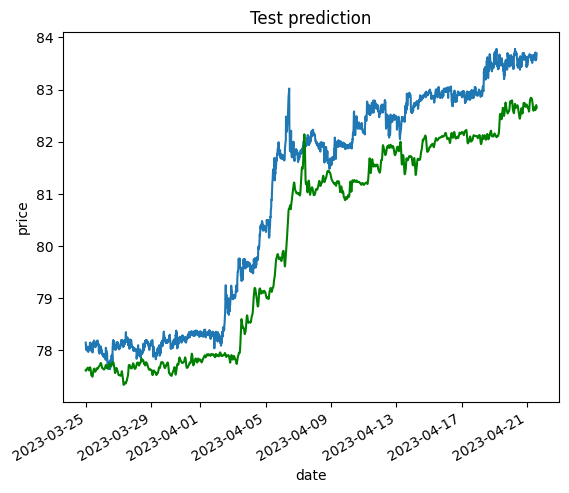

In [231]:
plt.plot(val_price.time, val_price.Close_price)
plt.plot(val_price.time, val_price.predict, color='green')

plt.title('Test prediction')

plt.xticks(rotation=30, ha='right')
plt.xlabel('date')
plt.ylabel('price')

### test  evaluation

In [234]:
test_results = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(model.metrics_names)
print(test_results)

1/1 [==============================] - 0s 94ms/step - loss: 0.0932 - mean_absolute_error: 0.3052
['loss', 'mean_absolute_error']
[0.09316737949848175, 0.3051843047142029]


In [233]:
test_predict = model.predict(x_test)
test_price['predict'] = test_predict*train_std.Close_price + train_mean.Close_price

1/1 [==============================] - 0s 320ms/step


In [237]:
val_test_df = val_price.append(test_price)

<ipython-input-237-4067c1dd4e7e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_test_df = val_price.append(test_price)


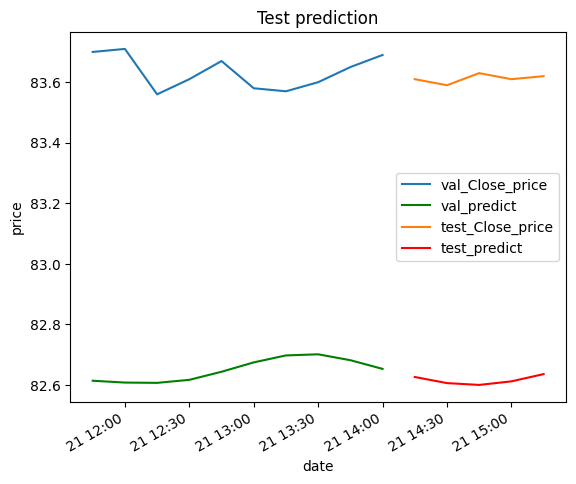

In [243]:
plt.plot(val_price.iloc[-10:].time, val_price.iloc[-10:].Close_price, label='val_Close_price')
plt.plot(val_price.iloc[-10:].time, val_price.iloc[-10:].predict, color='green', label = 'val_predict')

plt.plot(test_price.time, test_price.Close_price, label='test_Close_price')
plt.plot(test_price.time, test_price.predict, color='red', label='test_predict')

plt.title('Test prediction')

plt.xticks(rotation=30, ha='right')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()